# Forecasting with Linear Models on EMA Data

### 1. Importing Libraries and Reading Data

In [43]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import load_data

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [44]:
train_df, test_df, data_raw_list = load_data.load_alcohol()

patients_time = []
# Prepare the time series
print('Preparing the data for forecasting')
for i in range(len(data_raw_list)):
    patients_time.append(load_data.prepare_data_alcohol(data_raw_list[i]))

first_patient = patients_time[5]
first_patient.info()
first_patient.head()

Preparing the data for forecasting
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2018-02-14 14:50:00 to 2018-03-03 09:11:00
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   finish            114 non-null    datetime64[ns]
 1   drinks            114 non-null    float64       
 2   comfortable       114 non-null    float64       
 3   stressed          114 non-null    float64       
 4   down              114 non-null    float64       
 5   calm              114 non-null    float64       
 6   pressure          114 non-null    float64       
 7   enthusiastic      114 non-null    float64       
 8   happy             114 non-null    float64       
 9   conflict          114 non-null    float64       
 10  craving           114 non-null    float64       
 11  impulsive         114 non-null    float64       
 12  pos_expect        114 non-null    float64       
 13  peer_per

,finish,drinks,comfortable,stressed,down,calm,pressure,enthusiastic,happy,conflict,...,impulsive,pos_expect,peer_percent,want_drink,delay_grat,angry,drink_predict,restless_sleep,difficulty_sleep,hours_sleep
start,,,,,,,,,,,,,,,,,,,,,
2018-02-14 14:50:00,2018-02-14 15:06:00,0.0,17.0,84.0,55.0,20.0,0.0,45.0,44.0,0.0,...,29.0,79.0,7.0,62.0,40.0,0.0,13.0,16.0,10.0,6.5
2018-02-14 16:52:00,2018-02-14 17:07:00,0.0,100.0,82.0,75.0,25.0,0.0,16.0,20.0,0.0,...,9.0,80.0,9.0,74.0,62.0,68.0,NaN,NaN,NaN,NaN
2018-02-14 18:52:00,2018-02-14 18:58:00,0.0,53.0,64.0,58.0,27.0,0.0,57.0,39.0,0.0,...,13.0,67.0,13.0,70.0,66.0,36.0,NaN,NaN,NaN,NaN
2018-02-14 20:50:00,2018-02-14 20:52:00,0.0,100.0,72.0,67.0,36.0,0.0,31.0,26.0,0.0,...,0.0,65.0,18.0,65.0,69.0,31.0,NaN,NaN,NaN,NaN
2018-02-14 22:21:00,2018-02-14 22:29:00,0.0,100.0,70.0,71.0,21.0,2.0,22.0,30.0,0.0,...,24.0,70.0,20.0,71.0,66.0,40.0,NaN,NaN,NaN,NaN


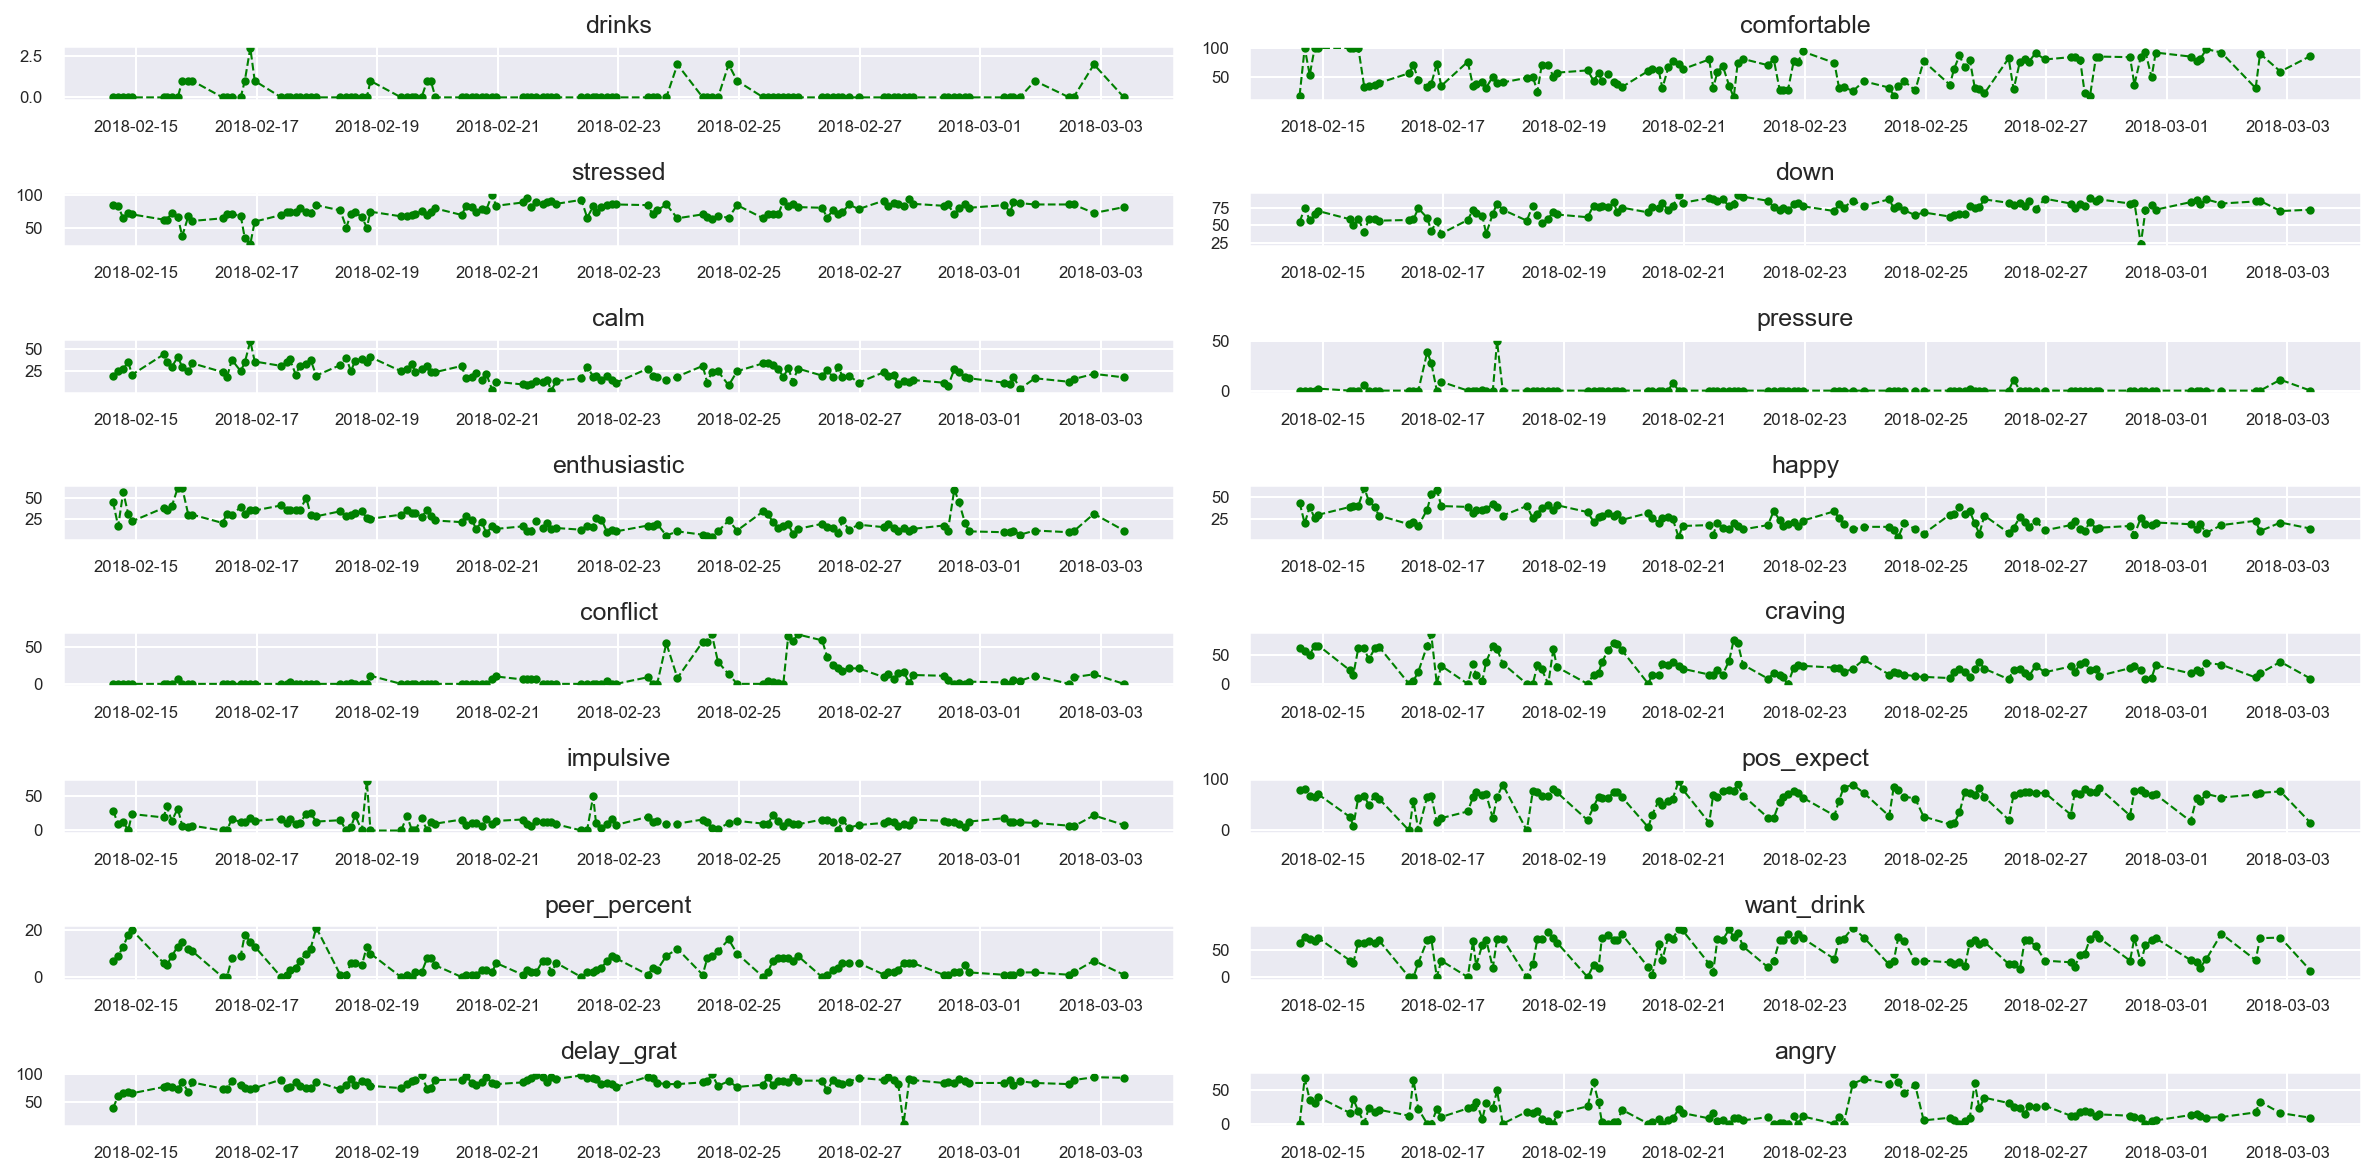

In [45]:
# Plot the data for one of the patients
fig, axes = plt.subplots(nrows=8, ncols=2)
for i, ax in enumerate(axes.flatten()):
    data = first_patient[first_patient.columns[i + 1]]
    ax.plot(data, color='green', marker='o', linestyle='dashed', linewidth=1, markersize=3)
    ax.set_title(first_patient.columns[i + 1])
    ax.tick_params(labelsize=8)
    ax.yaxis.set_ticks_position('none')

plt.tight_layout()
plt.show()

In [46]:
from scipy import stats

# ADF-Test for stationarity
first_patient = first_patient.drop(
    columns=['finish', 'drink_predict', 'restless_sleep', 'difficulty_sleep', 'hours_sleep'])
first_patient = first_patient.fillna(0)


def forecast_accuracy(forecast, actual):
    print('MAPE:', np.mean(np.abs(forecast - actual) / np.abs(actual)))
    print('ME:', np.mean(forecast - actual))
    print('MAE:', np.mean(np.abs(forecast - actual)))
    print('MPE:', np.mean((forecast - actual) / actual))
    print('RMSE:', np.mean((forecast - actual) ** 2) ** .5)
    print('CORR:', np.corrcoef(forecast, actual)[0, 1])


def difference(data):
    return data.diff().dropna()


def revert_diff(column, first_element):
    return column.cumsum().fillna(0) + first_element


def is_stationary(patient_data):
    stationary = []
    for name, column in patient_data.iteritems():
        p_value = adfuller(column, autolag='AIC')[1]
        # print('ADF Test for', name, ', p-value:', round(p_value, 4))
        stationary.append(p_value < 0.05)
    return all(stationary)


differences = 0
# Split into train and test sets

df_differenced = first_patient.copy()
print('All stationary:', is_stationary(patient_data=df_differenced))
while not is_stationary(patient_data=df_differenced):
    differences += 1
    df_differenced = difference(df_differenced)
print('Differences:', differences)
print('All stationary:', is_stationary(patient_data=df_differenced))

observations = 25
df_train, df_test = df_differenced[:-observations], df_differenced[-observations:]
df_differenced.head()

All stationary: False
Differences: 1
All stationary: True


,drinks,comfortable,stressed,down,calm,pressure,enthusiastic,happy,conflict,craving,impulsive,pos_expect,peer_percent,want_drink,delay_grat,angry
start,,,,,,,,,,,,,,,,
2018-02-14 16:52:00,0.0,83.0,-2.0,20.0,5.0,0.0,-29.0,-24.0,0.0,-5.0,-20.0,1.0,2.0,12.0,22.0,68.0
2018-02-14 18:52:00,0.0,-47.0,-18.0,-17.0,2.0,0.0,41.0,19.0,0.0,-7.0,4.0,-13.0,4.0,-4.0,4.0,-32.0
2018-02-14 20:50:00,0.0,47.0,8.0,9.0,9.0,0.0,-26.0,-13.0,0.0,16.0,-13.0,-2.0,5.0,-5.0,3.0,-5.0
2018-02-14 22:21:00,0.0,0.0,-2.0,4.0,-15.0,2.0,-9.0,4.0,0.0,0.0,24.0,5.0,2.0,6.0,-3.0,9.0
2018-02-15 10:57:00,0.0,0.0,-8.0,-12.0,23.0,-2.0,16.0,9.0,0.0,-43.0,-5.0,-44.0,-14.0,-41.0,11.0,-24.0


### 2. VAR Model

In [47]:
# Fit Vector Autoregression Model (VAR)
model = VAR(df_train)
x = model.select_order(maxlags=4)
print(x.summary())

model = model.fit(x.aic)
forecast = model.forecast(y=df_train.values[-x.aic:], steps=df_test.shape[0])
df_forecast = pd.DataFrame(forecast, index=first_patient.index[-df_test.shape[0]:], columns=first_patient.columns)

if differences == 1:
    for col in df_forecast.columns:
        df_forecast[col + '_prediction'] = revert_diff(df_forecast[col], first_patient[col].iloc[-observations - 1])

df_forecast = df_forecast.loc[:, ['craving_prediction', 'want_drink_prediction']]

df_forecast.head()

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       73.77      74.23*   1.092e+32       73.96
1       71.58       79.45   1.341e+31       74.75
2       70.59       85.87   9.301e+30       76.74
3       67.10       89.79   2.051e+30       76.22
4      52.77*       82.86  2.980e+26*      64.87*
-------------------------------------------------


C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,craving_prediction,want_drink_prediction
start,,
2018-02-26 17:07:00,13.634737,16.840378
2018-02-26 19:45:00,45.545129,67.768713
2018-02-26 23:33:00,44.203380,109.128937
2018-02-27 09:44:00,48.435920,35.197854
2018-02-27 11:22:00,11.891653,41.718620


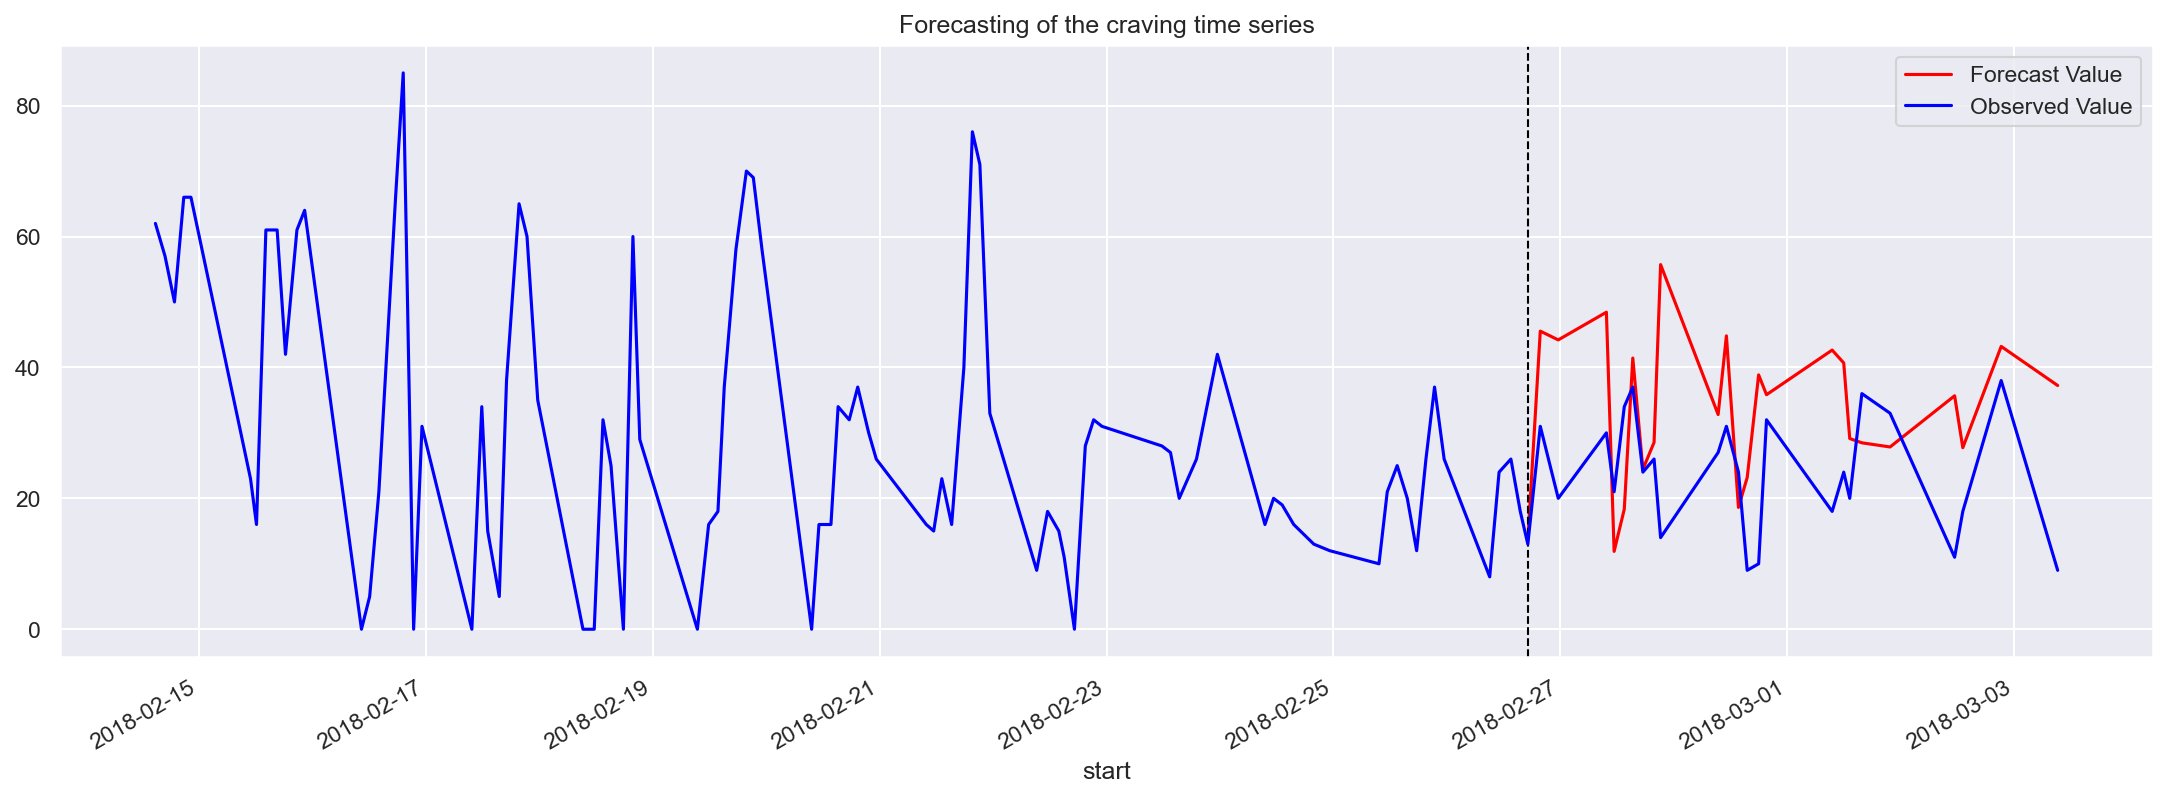

In [48]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_test.index, df_forecast['craving_prediction'], color='red', label='Forecast Value')

plt.axvline(df_test.index[0], c='black', ls='--', lw=1)
first_patient.plot(y='craving', color='blue', ax=ax, label='Observed Value')

plt.legend(loc='upper right')
plt.title('Forecasting of the craving time series')

plt.show()

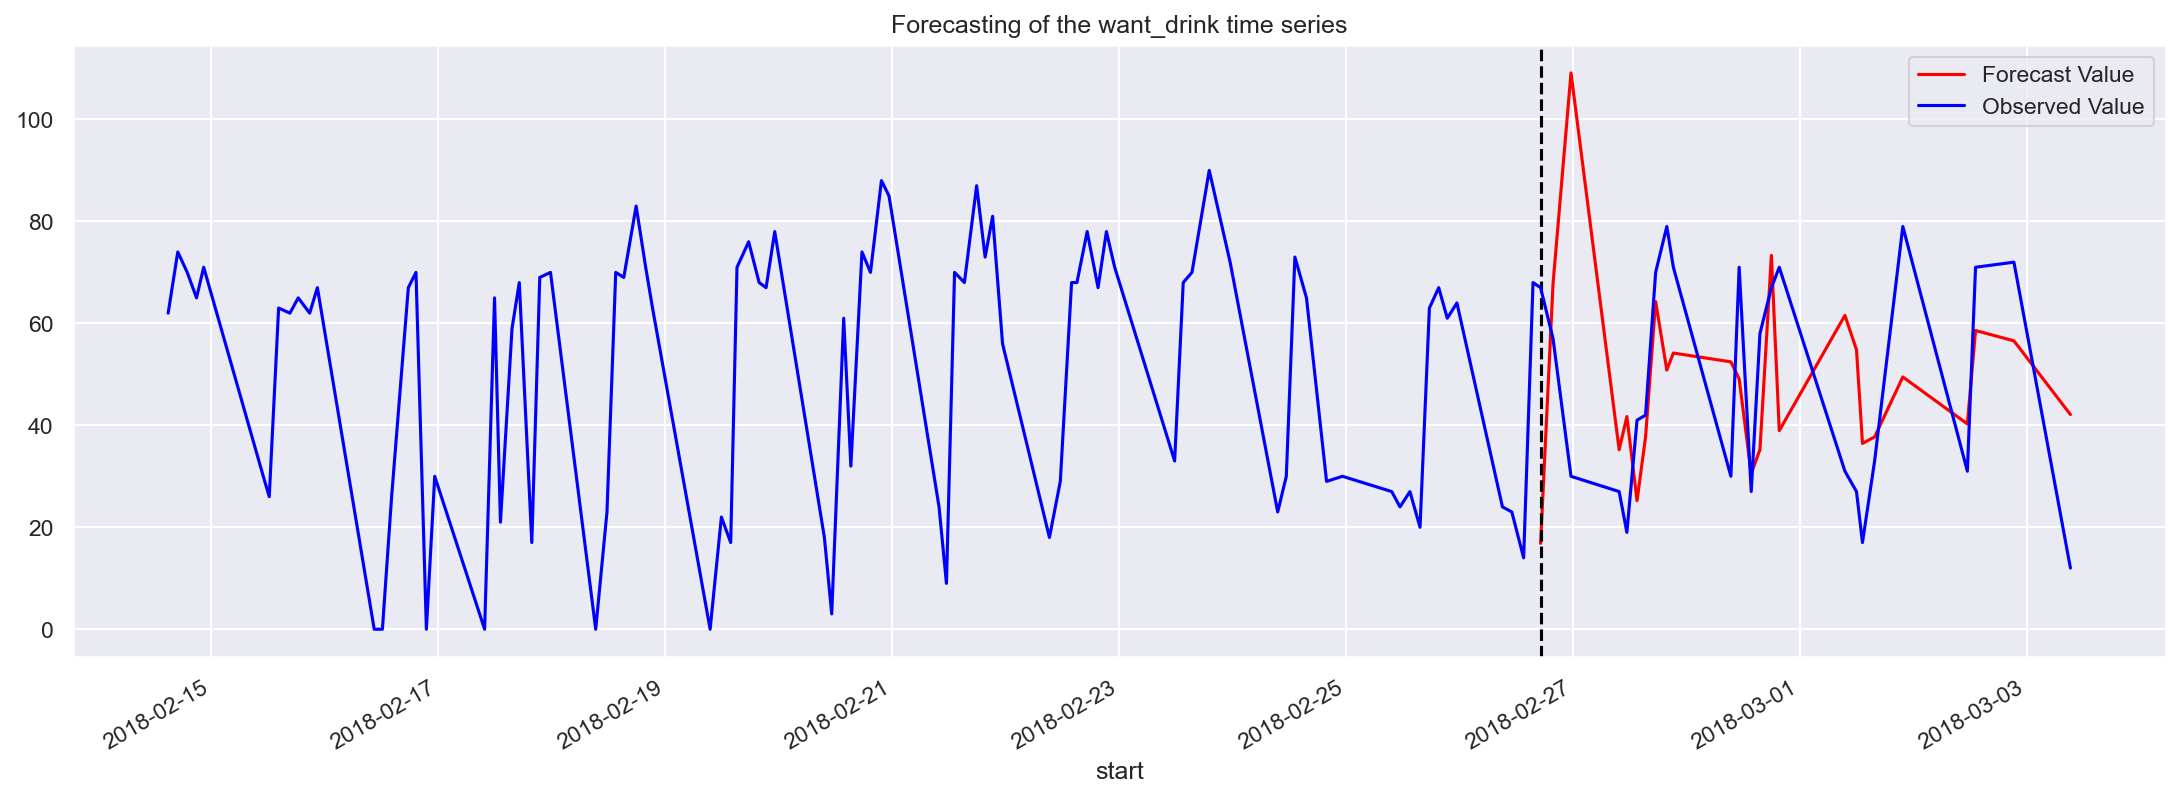

In [49]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_test.index, df_forecast['want_drink_prediction'], color='red', label='Forecast Value')

plt.axvline(df_test.index[0], c='black', ls='--')
first_patient.plot(y='want_drink', color='blue', ax=ax, label='Observed Value')

plt.legend(loc='upper right')
plt.title('Forecasting of the want_drink time series')

plt.show()